### Imports

In [ ]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score


#Libraries for Deep Learning Models
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD

#Libraries for Saving the Model
from pickle import dump
from pickle import load

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

<a id='1.2'></a>
## 2.2. Loading the Data

In [ ]:
# load dataset
dataset = pd.read_csv('LoansData_sample.csv', index_col=0)

In [ ]:
print(f"shape of dataset:{dataset.shape}")
dataset.info()

shape of dataset:(100000, 150)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Columns: 150 entries, id to settlement_term
dtypes: float64(115), int64(1), object(34)
memory usage: 115.2+ MB


In [ ]:
dataset.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,38098114,NaN,15000.0,15000.0,15000.0,60 months,12.39,336.64,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,36805548,NaN,10400.0,10400.0,10400.0,36 months,6.99,321.08,A,A3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,37842129,NaN,21425.0,21425.0,21425.0,60 months,15.59,516.36,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,37612354,NaN,12800.0,12800.0,12800.0,60 months,17.14,319.08,D,D4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,37662224,NaN,7650.0,7650.0,7650.0,36 months,13.66,260.20,C,C3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# 아래의 column들은 사용하지 않을 것이기 때문에 제거해주기로 한다.
dataset.drop(['id','member_id','emp_title','title','zip_code'], axis=1, inplace=True)

In [ ]:
# 일부 열 들은 결측치가 매우 많음을 확인할 수 있다.
# 추후에 이 열들을 제거하거나 결측치들을 따로 처리해 줄 필요가 있을 것 같다.
dataset.isnull().sum().sort_values(ascending=False).head(20)

sec_app_open_act_il                   100000
sec_app_collections_12_mths_ex_med    100000
sec_app_num_rev_accts                 100000
all_util                              100000
sec_app_revol_util                    100000
sec_app_open_acc                      100000
sec_app_mort_acc                      100000
sec_app_inq_last_6mths                100000
sec_app_earliest_cr_line              100000
sec_app_fico_range_high               100000
sec_app_fico_range_low                100000
revol_bal_joint                       100000
inq_last_12m                          100000
annual_inc_joint                      100000
dti_joint                             100000
verification_status_joint             100000
total_cu_tl                           100000
inq_fi                                100000
open_acc_6m                           100000
open_act_il                           100000
dtype: int64

### EDA + feature_selection

### 3.1. Preparing the predicted variable


In [ ]:
# loan_status를 예측변수로 사용할 것이다.
dataset['loan_status'].value_counts(dropna=False)

Fully Paid            69982
Charged Off           16156
Current               12726
Late (31-120 days)      730
In Grace Period         264
Late (16-30 days)       139
Default                   3
Name: loan_status, dtype: int64

In [ ]:
# 모든 상태를 다 사용하지 않고, Fully paid와 Charged off 두 가지 상태만을 사용하기로 함
# 상당히 불균형 한 데이터라는 것을 알 수 있다
dataset = dataset.loc[dataset['loan_status'].isin(['Fully Paid', 'Charged Off'])]
dataset['loan_status'].value_counts(normalize=True, dropna=False)

Fully Paid     0.812441
Charged Off    0.187559
Name: loan_status, dtype: float64

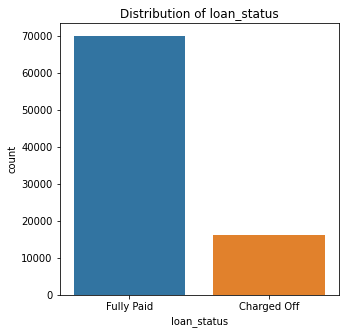

In [ ]:
plt.figure(figsize=(5,5))
sns.countplot(dataset['loan_status'])
plt.title("Distribution of loan_status")
plt.show()

In [ ]:
dataset['loan_status'] = dataset['loan_status'].apply(lambda x: 1 if x == 'Fully Paid' else 0)

<a id='2.2'></a>
## 3.2. Feature Selection-Limit the Feature Space 

The full dataset has 150 features for each
loan. We’ll eliminate
features in following steps using three different approaches:
* Eliminate feature that have more than 20% missing values.
* Eliminate features that are unintuitive based on subjective judgement.
* Eliminate features with low correlation with the predicted variable.

* Following steps above we'll choose 35 features.

### 3.2.1.  Features elimination by significant missing values

First calculating the percentage of missing data for each feature:

In [ ]:
# 결측치의 비중이 0.2을 넘는 특징들은 제외하기로 한다.
missing_fractions = dataset.isnull().mean().sort_values(ascending=False)
missing_fractions.head(10)

sec_app_open_act_il         1.0
annual_inc_joint            1.0
sec_app_num_rev_accts       1.0
all_util                    1.0
sec_app_revol_util          1.0
sec_app_open_acc            1.0
sec_app_mort_acc            1.0
sec_app_inq_last_6mths      1.0
sec_app_earliest_cr_line    1.0
sec_app_fico_range_high     1.0
dtype: float64

In [ ]:
drop_list = sorted(list(missing_fractions[missing_fractions > 0.2].index))
print(drop_list)

['all_util', 'annual_inc_joint', 'debt_settlement_flag_date', 'deferral_term', 'desc', 'dti_joint', 'hardship_amount', 'hardship_dpd', 'hardship_end_date', 'hardship_last_payment_amount', 'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount', 'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type', 'il_util', 'inq_fi', 'inq_last_12m', 'max_bal_bc', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_rcnt_il', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'next_pymnt_d', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m', 'orig_projected_additional_accrued_interest', 'payment_plan_start_date', 'revol_bal_joint', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_earliest_cr_line', 'sec_app_fico_range_high', 'sec_app_fico_range_low', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_mths_since_last_major_derog', '

In [ ]:
len(drop_list)

57

In [ ]:
dataset.drop(labels=drop_list, axis=1, inplace=True)
dataset.shape

(86138, 88)

### 3.2.2.  Features elimination based on the intutiveness

In order to filter the features further we check the description in the data dictionary and keep the features that are
intuitive on the basis of subjective judgement. 

We examine the LendingClub website and Data Dictionary to determine which features would have been available to potential investors. Here's the list of features we currently have, in alphabetical order:

In [ ]:
print(sorted(dataset.columns))

['acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'annual_inc', 'application_type', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 'disbursement_method', 'dti', 'earliest_cr_line', 'emp_length', 'fico_range_high', 'fico_range_low', 'funded_amnt', 'funded_amnt_inv', 'grade', 'hardship_flag', 'home_ownership', 'initial_list_status', 'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d', 'loan_amnt', 'loan_status', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd

The list that is kept is as follows: 

In [ ]:
keep_list = ['charged_off','funded_amnt','addr_state', 'annual_inc', 'application_type', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'grade', 'home_ownership', 'id', 'initial_list_status', 'installment', 'int_rate', 'loan_amnt', 'loan_status', 'mort_acc', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'term', 'title', 'total_acc', 'verification_status', 'zip_code','last_pymnt_amnt','num_actv_rev_tl', 'mo_sin_rcnt_rev_tl_op','mo_sin_old_rev_tl_op',"bc_util","bc_open_to_buy","avg_cur_bal","acc_open_past_24mths" ]

len(keep_list)

40

In [ ]:
drop_list = [col for col in dataset.columns if col not in keep_list]

dataset.drop(labels=drop_list, axis=1, inplace=True)

dataset.shape

(86138, 35)

<a id='2.2.3'></a>
### 3.2.3.  Features elimination based on the correlation

In [ ]:
correlation = dataset.corr()
correlation_loan_status = abs(correlation['loan_status'])

In [ ]:
correlation_loan_status.sort_values(ascending=False)

loan_status              1.000000
last_pymnt_amnt          0.319081
int_rate                 0.282825
dti                      0.123108
fico_range_low           0.121892
fico_range_high          0.121891
acc_open_past_24mths     0.105989
bc_open_to_buy           0.080077
bc_util                  0.077744
avg_cur_bal              0.071977
num_actv_rev_tl          0.071185
revol_util               0.066188
loan_amnt                0.060818
funded_amnt              0.060818
mort_acc                 0.057858
annual_inc               0.050349
mo_sin_old_rev_tl_op     0.049426
mo_sin_rcnt_rev_tl_op    0.048839
open_acc                 0.039430
installment              0.032847
revol_bal                0.021714
pub_rec                  0.016023
pub_rec_bankruptcies     0.015815
total_acc                0.005804
Name: loan_status, dtype: float64

In [ ]:
drop_list_corr = sorted(list(correlation_loan_status[correlation_loan_status < 0.03].index))
print(drop_list_corr)

['pub_rec', 'pub_rec_bankruptcies', 'revol_bal', 'total_acc']


In [ ]:
dataset.drop(labels=drop_list_corr, axis=1, inplace=True)
dataset.shape

(86138, 31)

<a id='3'></a>
# 4. Feature Engineering and Exploratory Analysis

In [ ]:
dataset.describe()

,loan_amnt,funded_amnt,int_rate,installment,annual_inc,loan_status,dti,fico_range_low,fico_range_high,open_acc,revol_util,last_pymnt_amnt,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,num_actv_rev_tl
count,86138.000000,86138.000000,86138.000000,86138.000000,8.613800e+04,86138.000000,86138.000000,86138.000000,86138.000000,86138.000000,86094.000000,86138.000000,86138.000000,86138.000000,85142.000000,85089.000000,86138.000000,86138.000000,86138.000000,86138.000000
mean,14106.526446,14106.526446,13.002360,430.737187,7.384311e+04,0.812441,18.532747,692.462966,696.463024,11.746453,54.582777,4757.453184,4.594732,13066.638371,8942.506507,63.808959,183.524333,12.796896,1.748880,5.762358
std,8391.139221,8391.139221,4.397419,251.653139,5.929352e+04,0.390362,8.538247,29.731549,29.731848,5.433122,23.515901,6466.767327,3.070996,16232.739293,14100.186250,27.051347,93.266430,16.224586,2.091488,3.224598
min,1000.000000,1000.000000,6.000000,30.420000,4.000000e+03,0.000000,0.000000,660.000000,664.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000
25%,7800.000000,7800.000000,9.490000,248.480000,4.500000e+04,1.000000,12.070000,670.000000,674.000000,8.000000,37.200000,358.522500,2.000000,3010.000000,1087.000000,44.100000,118.000000,3.000000,0.000000,3.000000
50%,12000.000000,12000.000000,12.990000,370.480000,6.247372e+04,1.000000,17.950000,685.000000,689.000000,11.000000,54.900000,1241.230000,4.000000,6994.500000,3823.000000,67.700000,167.000000,8.000000,1.000000,5.000000
75%,20000.000000,20000.000000,15.610000,568.005000,9.000000e+04,1.000000,24.500000,705.000000,709.000000,14.000000,72.500000,7303.205000,6.000000,17905.000000,10588.000000,87.500000,232.000000,15.000000,3.000000,7.000000
max,35000.000000,35000.000000,26.060000,1408.130000,7.500000e+06,1.000000,39.990000,845.000000,850.000000,84.000000,180.300000,36234.440000,53.000000,447433.000000,249625.000000,255.200000,718.000000,372.000000,34.000000,38.000000


<a id='3.1'></a>
## 4.1 Feature Analysis and Exploration

<a id='3.1.1'></a>
### 4.1.1. Analysing the categorical features 

#### Feature- Term

In [ ]:
#Data Dictionary: "The number of payments on the loan. Values are in months and can be either 36 or 60.". 
#The 60 Months loans are more likelely to charge off
#Convert term to integers
dataset['term'] = dataset['term'].apply(lambda s: np.int8(s.split()[0]))

In [ ]:
# term이 36인 경우, 갚을 확률이 86%, term이 60인 경우, 갚을 확률이 64.5%
dataset.groupby('term')['loan_status'].value_counts(normalize=True).loc[:,1]

term
36    0.858474
60    0.645644
Name: loan_status, dtype: float64

Loans with five-year periods are more than twice as likely to charge-off as loans with three-year periods.

#### Feature- Employement Length

In [ ]:
dataset['emp_length'].replace(to_replace='10+ years', value='10 years', inplace=True)

dataset['emp_length'].replace('< 1 year', '0 years', inplace=True)

def emp_length_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])
    
dataset['emp_length'] = dataset['emp_length'].apply(emp_length_to_int)


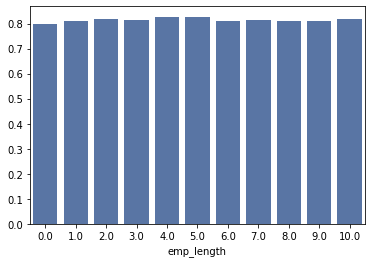

In [ ]:
loan_status = dataset.groupby('emp_length')['loan_status'].value_counts(normalize=True).loc[:,1]
sns.barplot(x=loan_status.index, y=loan_status.values, color='#5975A4', saturation=1)

 Loan status does not appear to vary much with employment length on average, hence it is dropped

In [ ]:
dataset.drop(['emp_length'], axis=1, inplace=True)

#### Feature : Subgrade

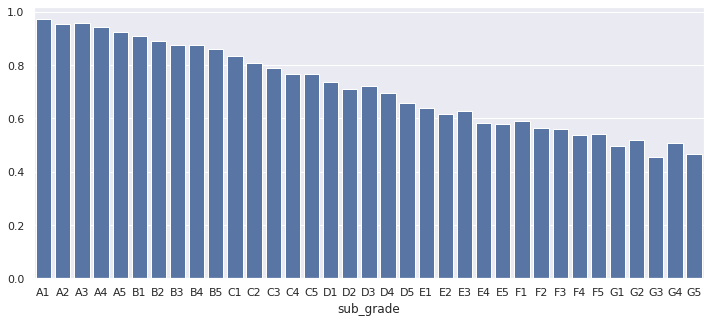

In [ ]:
charge_off_rates = dataset.groupby('sub_grade')['loan_status'].value_counts(normalize=True).loc[:,1]
sns.set(rc={'figure.figsize':(12,5)})
sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='#5975A4', saturation=1)

There's a clear trend of higher probability of charge-off as the subgrade worsens.

In [ ]:
dataset['earliest_cr_line'] = dataset['earliest_cr_line'].apply(lambda s: int(s[-4:]))

<a id='3.1.2'></a>
### 4.1.2. Analysing the continuous features 

#### Feature : Annual Income

In [ ]:
dataset[['annual_inc']].describe()

,annual_inc
count,8.613800e+04
mean,7.384311e+04
std,5.929352e+04
min,4.000000e+03
25%,4.500000e+04
50%,6.247372e+04
75%,9.000000e+04
max,7.500000e+06


Annual income ranges from 0  to  9,550,000, with a median of $65,000. 
Because of the large range of incomes, we should take a log transform of the annual income variable.

In [ ]:
dataset['log_annual_inc'] = dataset['annual_inc'].apply(lambda x: np.log10(x+1))
dataset.drop('annual_inc', axis=1, inplace=True)

#### FICO Scores

In [ ]:
dataset[['fico_range_low','fico_range_high']].corr()

,fico_range_low,fico_range_high
fico_range_low,1.0,1.0
fico_range_high,1.0,1.0


Given that the correlation between fico low and high is 1 it is preferred to keep only one feature which is average of FICO Scores

In [ ]:
dataset['fico_score'] = 0.5*dataset['fico_range_low'] + 0.5*dataset['fico_range_high']

dataset.drop(['fico_range_high', 'fico_range_low'], axis=1, inplace=True)

<a id='3.2'></a>
## 4.2. Encoding Categorical Data

In [ ]:
# Categorical boolean mask
categorical_feature_mask = dataset.dtypes==object
# filter categorical columns using mask and turn it into a list
categorical_cols = dataset.columns[categorical_feature_mask].tolist()

In [ ]:
# 돈을 갚을 확률이 가장 낮은 분류부터 순서대로 0부터 encoding하기로 함
# purpose에서 돈을 갚을 확률이 가장 낮은 분류가 0, 그 다음으로 낮은 분류가 1, ...
def encoding_by_loan_status(data, column):
  index_list = data.groupby(column)['loan_status'].mean().sort_values(ascending=True).index
  map_dict = {}
  for i, index in enumerate(index_list):
    map_dict[index] = i
  data[[column]] = data[[column]].applymap(map_dict.get)

In [ ]:
for col in categorical_cols:
  encoding_by_loan_status(dataset, col)

In [ ]:
print(f"shape of dataset: {dataset.shape}")
dataset.head()

shape of dataset: (86138, 29)


,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,home_ownership,verification_status,loan_status,...,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,num_actv_rev_tl,log_annual_inc,fico_score
0,15000.0,15000.0,60,12.39,336.64,4,24,0,1,1,...,5.0,29828.0,9525.0,4.7,244.0,1.0,0.0,4.0,4.892100,752.0
1,10400.0,10400.0,36,6.99,321.08,6,33,2,2,0,...,7.0,9536.0,7599.0,41.5,290.0,1.0,1.0,9.0,4.763435,712.0
2,21425.0,21425.0,60,15.59,516.36,3,19,0,1,1,...,4.0,4232.0,324.0,97.8,136.0,7.0,0.0,4.0,4.804827,687.0
4,7650.0,7650.0,36,13.66,260.20,4,22,0,1,0,...,6.0,5857.0,332.0,93.2,148.0,8.0,0.0,4.0,4.698979,687.0
5,9600.0,9600.0,36,13.66,326.53,4,22,0,1,1,...,8.0,3214.0,6494.0,69.2,265.0,23.0,0.0,7.0,4.838855,682.0


## 4.3. Sampling Data, Scaling, and spliting the dataset

In [ ]:
#Filling the NAs with the mean of the column.
dataset.fillna(dataset.median(),inplace = True)

In [ ]:
from imblearn.under_sampling import *
from imblearn.over_sampling import *
from imblearn.combine import *

X = dataset.drop('loan_status', axis=1)
y = dataset[['loan_status']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y )

In [ ]:
# scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

<a id='4'></a>
# 5. Evaluate Algorithms and Models


## 5.1. Test Options and Evaluation Metrics


In [ ]:
# test options for classification
num_folds = 10
seed = 42
#scoring = 'accuracy'
scoring ='precision'
#scoring ='recall'
#scoring = 'roc_auc'

<a id='4.3'></a>
## 5.3. Compare Models and Algorithms

### Classification Models

In [ ]:
# spot check the algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#Neural Network
models.append(('NN', MLPClassifier()))
#Ensable Models 
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier()))
models.append(('ET', ExtraTreesClassifier()))

### K-folds cross validation

In [ ]:
results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.889705 (0.002150)
LDA: 0.884574 (0.002273)
KNN: 0.880406 (0.002157)
CART: 0.913820 (0.002464)
NB: 0.946021 (0.002842)
NN: 0.902750 (0.008195)
AB: 0.901591 (0.002631)
GBM: 0.901655 (0.002972)
RF: 0.899002 (0.002623)
ET: 0.887658 (0.002020)


### Algorithm comparison

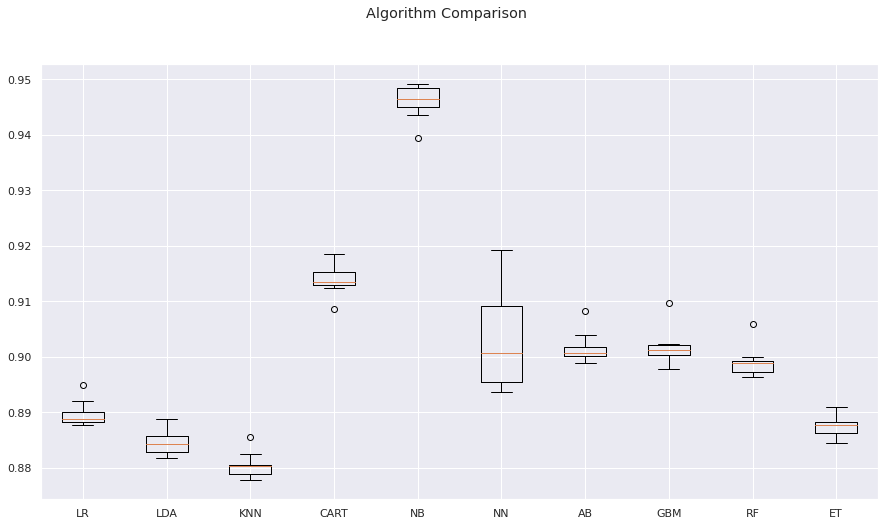

In [ ]:
# compare algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

<a id='5'></a>
# 6. Model Tuning and Grid Search

Given that the ETC is the best model, Grid Search is performed on ETC in this step.

In [ ]:
#  Grid Search: ExtraTreesClassifier Tuning
# '''
# n_estimators : int (default=100)
#     The number of boosting stages to perform. 
# max_depth : integer, optional (default=3)
#     maximum depth of the individual regression estimators. 
#     The maximum depth limits the number of nodes in the tree. 
#     Tune this parameter for best performance; the best value depends on the interaction of the input variables.

# ''' 
# n_estimators = [50,500]
# max_depth= [3,5]
# param_grid = dict(n_estimators=n_estimators, max_depth=max_depth)
# model = ExtraTreesClassifier()
# kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
# grid_result = grid.fit(X_train, y_train)

# Print Results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# ranks = grid_result.cv_results_['rank_test_score']
# for mean, stdev, param, rank in zip(means, stds, params, ranks):
#     print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

<a id='6'></a>
# 7. Finalise the Model

Looking at the details above GBM might be worthy of further study, but for now SVM shows a lot of promise as a low complexity and stable model for this problem.

Finalize Model with best parameters found during tuning step.

<a id='6.1'></a>
## 7.1. Results on the Test Dataset

In [ ]:
# prepare model
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier()

In [ ]:
# estimate accuracy on validation set
predictions = model.predict(X_test)
print(accuracy_score(y_test, predictions))
print(precision_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.8545971674019038
0.9118405963302753
[[ 2001  1230]
 [ 1275 12722]]
              precision    recall  f1-score   support

           0       0.61      0.62      0.62      3231
           1       0.91      0.91      0.91     13997

    accuracy                           0.85     17228
   macro avg       0.76      0.76      0.76     17228
weighted avg       0.86      0.85      0.85     17228



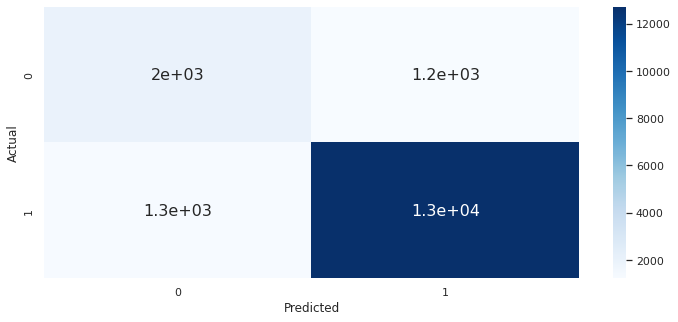

In [ ]:
df_cm = pd.DataFrame(confusion_matrix(y_test, predictions), columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font sizes

<a id='6.2'></a>
## 7.2. Variable Intuition/Feature Importance
Looking at the details above GBM might be worthy of further study.
Let us look into the Feature Importance of the GBM model

[0.01225137 0.00681656 0.18701611 0.01980946 0.03530615 0.02936872
 0.01019277 0.0063967  0.00523119 0.00806863 0.02323559 0.03989993
 0.01641212 0.02081187 0.02971467 0.00389756 0.31262212 0.
 0.01814613 0.03505505 0.03111462 0.02606778 0.03065962 0.01901902
 0.009485   0.01612189 0.02862123 0.01865813]


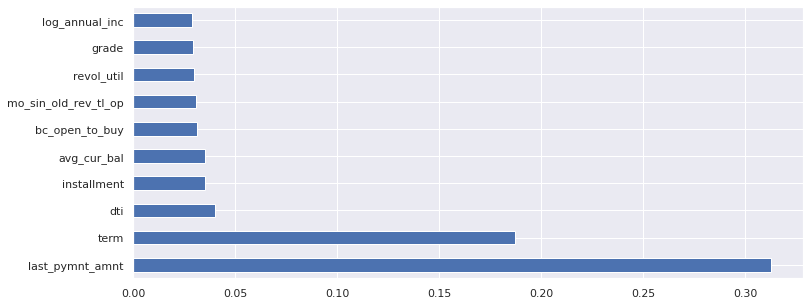

In [ ]:
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

__Conclusion__:

We showed that data preparation is one of the most important steps. We addressed
that by performing feature elimination by using different techniques such as subjec‐
tive judgement, correlation, visualization and the data quality of the feature.
We illustrated that there can be different ways of handling and analyzing the categorical data and converting categorical data into model usable format.

Finally, we analyzed the feature importance and found that results of the case study
are quite intuitive.

